<a href="https://colab.research.google.com/github/bhanudeergasi/NullClass_Data_science_internship/blob/main/task5_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Objective:
To refine a pre-trained text-to-image model (Stable Diffusion) using a custom dataset in the artwork domain, so it can generate more domain-specific and style-consistent visuals.

I have  chosen the artwork domain and used image-caption pairs representing various painting styles (cubism, surrealism, modern art, etc.).



#Installing the dependencies

In [ ]:
!pip install -q diffusers transformers accelerate datasets
!pip install -q bitsandbytes
!pip install -q safetensors




Mount Google Drive

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Imports

In [ ]:
from diffusers import StableDiffusionPipeline, UNet2DConditionModel, AutoencoderKL, DDPMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from PIL import Image
import torch, json, os
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from tqdm.auto import tqdm

Setting up the project Paths


In [ ]:
project_path = "/content/drive/MyDrive/TASK5"
dataset_path = os.path.join(project_path, "artwork_dataset")
image_folder = os.path.join(dataset_path, "images")
caption_path = os.path.join(dataset_path, "captions.json")

device = "cuda" if torch.cuda.is_available() else "cpu"


Create Dataset Class

In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import json

class ArtDataset(Dataset):
    def __init__(self, image_dir, captions_file, transform=None):
        self.image_dir = image_dir
        self.transform = transform

        # Load captions
        with open(captions_file, "r") as f:
            self.captions = json.load(f)

        # Keep only files that actually exist in captions.json
        self.image_paths = []
        self.caption_texts = []

        for fname in sorted(os.listdir(image_dir)):
            if fname in self.captions:
                self.image_paths.append(os.path.join(image_dir, fname))
                self.caption_texts.append(self.captions[fname])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        caption = self.caption_texts[idx]
        return {"image": image, "caption": caption}


In [ ]:
import torchvision.transforms as T

# Set paths
image_folder = "/content/drive/MyDrive/TASK5/artwork_dataset/images"
captions_file = "/content/drive/MyDrive/TASK5/artwork_dataset/captions.json"

# Define transform
transform = T.Compose([
    T.Resize((512, 512)),
    T.ToTensor(),
    T.Normalize([0.5], [0.5])
])

# Re-create dataset and dataloader
dataset = ArtDataset(image_folder, captions_file, transform)
train_loader = DataLoader(dataset, batch_size=1, shuffle=True)

print(f" Found {len(dataset)} valid images with captions.")


✅ Found 10 valid images with captions.


 Define Transformations

In [ ]:
#  Load dataset with transform#
image_folder = os.path.join(project_path, "artwork_dataset/images")
captions_file = os.path.join(project_path, "artwork_dataset/captions.json")

transform = T.Compose([
    T.Resize((512, 512)),
    T.ToTensor(),
    T.Normalize([0.5], [0.5])
])
#Loading the Datasets
dataset = ArtDataset(image_folder, captions_file, transform)
train_loader = DataLoader(dataset, batch_size=1, shuffle=True)


Load Pretrained Components

In [ ]:
transform = T.Compose([
    T.Resize((512, 512)),
    T.ToTensor(),
    T.Normalize([0.5], [0.5])
])

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to(device)
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet").to(device)
noise_scheduler = DDPMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")


In [ ]:
# Freeze entire UNet
for param in unet.parameters():
    param.requires_grad = False

# Unfreeze attention blocks (lightweight tuning)
for name, module in unet.named_modules():
    if "attn" in name or "Attention" in name:
        for param in module.parameters():
            param.requires_grad = True


In [ ]:
dataset = ArtDataset(image_folder, caption_path, transform)
train_loader = DataLoader(dataset, batch_size=1, shuffle=True)


In [ ]:
from diffusers import StableDiffusionPipeline

# Load the pipeline
pipe = StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    torch_dtype=torch.float16,
    revision="fp16"
).to("cuda")

# Get the models from pipeline
tokenizer = pipe.tokenizer
text_encoder = pipe.text_encoder
vae = pipe.vae
unet = pipe.unet

# Optional: remove the full pipeline if not needed
del pipe
torch.cuda.empty_cache()


/usr/local/lib/python3.11/dist-packages/diffusers/pipelines/pipeline_loading_utils.py:325: FutureWarning: You are loading the variant fp16 from CompVis/stable-diffusion-v1-4 via `revision='fp16'`. This behavior is deprecated and will be removed in diffusers v1. One should use `variant='fp16'` instead. However, it appears that CompVis/stable-diffusion-v1-4 currently does not have the required variant filenames in the 'main' branch. 
 The Diffusers team and community would be very grateful if you could open an issue: https://github.com/huggingface/diffusers/issues/new with the title 'CompVis/stable-diffusion-v1-4 is missing fp16 files' so that the correct variant file can be added.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--stable-diffusion-v1-4/snapshots/2880f2ca379f41b0226444936bb7a6766a227587/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--CompVis--stable-diffusion-v1-4/snapshots/2880f2ca379f41b0226444936bb7a6766a227587/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--stable-diffusion-v1-4/snapshots/2880f2ca379f41b0226444936bb7a6766a227587/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--CompVis--stable-diffusion-v1-4/snapshots/2880f2ca379f41b0226444936bb7a6766a227587/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
/usr/local/lib/python3.11/dist-packages/transformers/models/clip/feature_extraction_clip.py:30

In [ ]:
for epoch in range(2):
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for batch in pbar:
        with torch.no_grad():
            input_ids = tokenizer(batch["caption"], padding="max_length", max_length=77, return_tensors="pt").input_ids.to("cuda")
            text_embed = text_encoder(input_ids)[0]  # Shape: [1, 77, 768]

        image = batch["image"].to("cuda", dtype=torch.float16)

        # Encode into latents
        latents = vae.encode(image * 2 - 1).latent_dist.sample() * 0.18215

        # Add noise
        noise = torch.randn_like(latents)
        timesteps = torch.randint(0, 1000, (1,), device="cuda").long()
        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

        # Predict noise
        noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states=text_embed).sample

        # Compute loss
        loss = torch.nn.functional.mse_loss(noise_pred, noise)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        pbar.set_postfix(loss=loss.item())


Epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
save_path = os.path.join(project_path, "finetuned_unet")
unet.save_pretrained(save_path)
print(" Finetuned UNet saved.")


✅ Finetuned UNet saved.


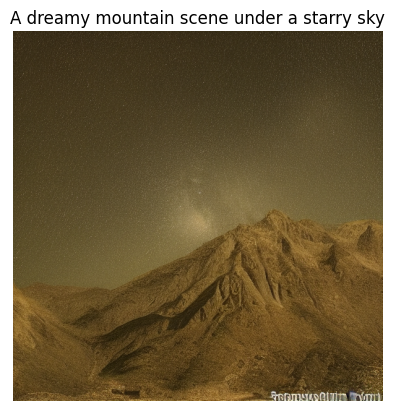

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_custom_image(prompt, vae, tokenizer, text_encoder, unet, scheduler, device="cuda"):
    # Tokenize prompt
    inputs = tokenizer(prompt, return_tensors="pt").input_ids.to(device)

    # Encode text and ensure correct dtype
    with torch.no_grad():
        text_embeddings = text_encoder(inputs)[0].to(dtype=torch.float16)

    # Initial random noise
    latents = torch.randn((1, 4, 64, 64), device=device, dtype=torch.float16)

    # Set timesteps
    scheduler.set_timesteps(50)

    for t in scheduler.timesteps:
        with torch.no_grad():
            noise_pred = unet(latents, t, encoder_hidden_states=text_embeddings).sample
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    # Decode latent to image
    with torch.no_grad():
        image = vae.decode(latents / 0.18215).sample

    # Post-process image
    image = image.detach().cpu().permute(0, 2, 3, 1)[0]
    image = (image * 0.5 + 0.5).clamp(0, 1)
    image = (image.numpy() * 255).astype("uint8")
    image = Image.fromarray(image)

    # Display image
    plt.imshow(image)
    plt.axis("off")
    plt.title(prompt)
    plt.show()

# Test it
generate_custom_image("A dreamy mountain scene under a starry sky", vae, tokenizer, text_encoder, unet, noise_scheduler)


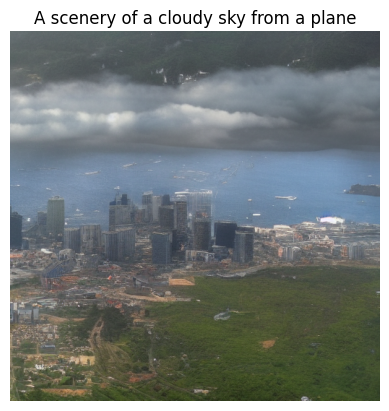

In [ ]:
generate_custom_image("A scenery of a cloudy sky from a plane", vae, tokenizer, text_encoder, unet, noise_scheduler)


 Enter your custom artwork prompt: A dreamy watercolor of a forest in autumn

 Generating image for: "A dreamy watercolor of a forest in autumn"


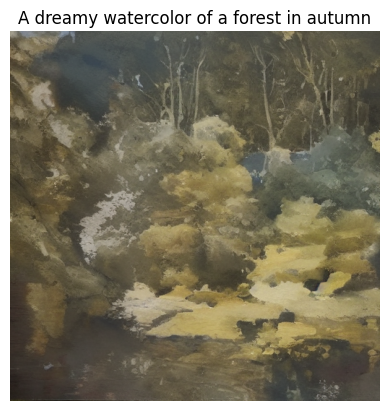

In [ ]:
#taking and generating the image with the custom input
# Prompt-based image generation from user input

# Ask user for prompt
user_prompt = input(" Enter your custom artwork prompt: ")

# Check if empty
if not user_prompt.strip():
    print(" Prompt cannot be empty.")
else:
    print(f"\n Generating image for: \"{user_prompt}\"")
    generate_custom_image(user_prompt, vae, tokenizer, text_encoder, unet, noise_scheduler)
